# Web2cit: up-to-date Citoid gap figures

This notebook describes how to retrieve the source code and the [Citation templates](https://en.wikipedia.org/wiki/Wikipedia:Citation_templates) of the references of a sample of Wikipedia articles to compare them with the results of the [Citoid](https://www.mediawiki.org/wiki/Citoid) API for the same references.

To follow along, we recommend running the script portions piecemeal, in order.

__Author:__

* Nidia Hernández, [nidiahernandez@conicet.gov.ar](mailto:nidiahy@gmail.com), CAICYT-CONICET


## Table of Contents

0. Setting Up 
1. Retrieving data from Wikipedia articles
    - 1.1. Fetching featured articles using Mediawiki's action API
    - 1.2. Retrieve featured articles data
2. Citation template metadata extraction
    - 2.1 Parameter name mapping
    - 2.2 Inspecting all featured articles
    - 2.3 Citation template extraction summary
3. Querying Citoid API
    - 3.1 Validate URLs
    - 3.2 Query function and parallel requests
    - 3.3 Tidy Citoid's response
4. Evaluating Citoid results
5. Visualizing results
    - 5.1. Tabular representation
    - 5.2. Other representations ...
6. ...
    - 6.1. ...
    - 6.2. ...

## 0. Setting Up

Before we get started, let's install and import the libraries that we will need.

In [5]:
import re
import os
import requests
import urllib
import pandas as pd
from operator import itemgetter
import json
import gzip
from glob import glob
from pprint import pprint
from tqdm import tqdm
tqdm.pandas()
import mwparserfromhell
import validators
from datetime import datetime
import concurrent.futures
from time import sleep
from more_itertools import chunked
from unidecode import unidecode
from ast import literal_eval
import dateparser
from nltk.metrics import edit_distance

Here we set the global parameters:

In [24]:
HEADER={'User-Agent': 'https://phabricator.wikimedia.org/tag/web2cit-research/; mailto:nidiahernandez@conicet.gov.ar'}

## 1. Retrieving data from Wikipedia articles

In this section, we will fetch all the featured articles from a selection of Wikipedias ir order to find:

- the citation templates used on each article
- the URLs of the citations

The selected Wikipedias are the following:

- [English Wikipedia](https://en.wikipedia.org/wiki/Category:Featured_articles): ~6k featured articles
- [Spanish Wikipedia](https://es.wikipedia.org/wiki/Categor%C3%ADa:Wikipedia:Art%C3%ADculos_destacados): ~1.2k artículos destacados
- [French Wikipedia](https://fr.wikipedia.org/wiki/Cat%C3%A9gorie:Article_de_qualit%C3%A9): ~2k articles de qualité
- [Portuguese Wikipedia](https://pt.wikipedia.org/wiki/Categoria:!Artigos_destacados): ~1.3k artigos destacados

Some general information about featured articles in all Wikipedias: https://meta.wikimedia.org/wiki/Wikipedia_featured_articles (out of date).

#### Featured content endpoint in Mediawiki's API

There is a specific endpoint for featured content in Mediawiki's API:

https://api.wikimedia.org/feed/v1/wikipedia/{lang}/featured/

For example, the request https://api.wikimedia.org/feed/v1/wikipedia/en/featured/2021/12/06 returns today's featured article (tfa) for December 6th 2021 in English Wikipedia.

Unfortunatatly, this is not avalilable for all the Wikipedias of our interest because "not all Wikipedias are integrated into the Feed endpoint" ([Feed endpoint doc](https://api.wikimedia.org/wiki/API_reference/Feed/Featured_content)). This way, the request https://api.wikimedia.org/feed/v1/wikipedia/fr/featured/2021/12/06 does not return tfa info. Same for Spanish and Portuguese. For this reason, we do not use this specific endpoint.

### 1.1 Fetching featured articles using Mediawiki's action API

We will use each [Wikipedias' action API](https://www.mediawiki.org/wiki/API:Main_page) to retrive:

1. the list of all featured articles for each language
2. the wikicode and some metadata of each featured article

The action API has the following URL:

`https://{lang}.wikipedia.org/w/api.php?`

The following request, for example, retrieves the first 15 featured articles for the category "Articles de qualité" in French Wikipedia:

In [3]:
title = urllib.parse.unquote("Cat%C3%A9gorie:Article_de_qualit%C3%A9") # category name for featured articles in French Wikipedia

PARAMS = {
    "action": "query",
    "list": "categorymembers",
    "cmtitle": title,
    "cmlimit": 15,
    "format": "json"
}

response = requests.get(
    url='https://fr.wikipedia.org/w/api.php?', 
    params=PARAMS
)

response_data = response.json()

There is a max of 500 per request. In order to retrieve all the members of the category, we should add the parameter `cmcontinue` to our request as follows: we get the value of `cmcontinue` from the response of the first request and pass it to the following request. This repeats until the end of the list. See API doc for more details on listing category members: https://www.mediawiki.org/wiki/API:Categorymembers.

In [4]:
response_data['continue']['cmcontinue'] # here is the reference of the starting point for the next request

'page|2a2e38324232443a30324e01428844880901dc10|52519'

In the response, we obtain a list showing the pageid and the title of each article:

In [5]:
response_data['query']['categorymembers']

[{'pageid': 507899, 'ns': 4, 'title': 'Wikipédia:Articles de qualité'},
 {'pageid': 9253139, 'ns': 0, 'title': '1 000 kilomètres de Spa 2009'},
 {'pageid': 10267261, 'ns': 0, 'title': '6 Heures du Castellet 2011'},
 {'pageid': 91996, 'ns': 0, 'title': '32X'},
 {'pageid': 605584, 'ns': 0, 'title': 'Les 101 Dalmatiens (film, 1961)'},
 {'pageid': 5008651, 'ns': 0, 'title': 'A Different Corner'},
 {'pageid': 639219, 'ns': 0, 'title': "A Hard Day's Night (album)"},
 {'pageid': 6672844, 'ns': 0, 'title': "À l'Olympia (album d'Alan Stivell)"},
 {'pageid': 124634, 'ns': 0, 'title': 'À la croisée des mondes'},
 {'pageid': 1486250, 'ns': 0, 'title': "L'Abbaye de Northanger"},
 {'pageid': 11085052, 'ns': 0, 'title': 'Abbaye Saint-Paul de Cormery'},
 {'pageid': 1210952, 'ns': 0, 'title': 'Abbaye Saint-Victor de Marseille'},
 {'pageid': 4293975, 'ns': 0, 'title': "Parc national d'Abisko"},
 {'pageid': 1415801, 'ns': 0, 'title': 'Acanthaster planci'},
 {'pageid': 3906668,
  'ns': 0,
  'title': 'Acci

If the item is a featured article, `ns` (namespace) is `0`. So, to avoid retriving other items (meta-pages about other categories, for example) elements having other values for this key must be discarded (cf. Retrieve article data below).

Let's request all the featured articles for each language and dump the response to a json:

In [6]:
# the name of the category in each language
catname_bylang = {
    'en': 'Category:Featured_articles',
    'es': 'Categor%C3%ADa:Wikipedia:Art%C3%ADculos_destacados',
    'fr': 'Cat%C3%A9gorie:Article_de_qualit%C3%A9',
    'pt': 'Categoria:!Artigos_destacados',
}

In [7]:
for lang in tqdm(catname_bylang, desc='Retrieving featured articles'):
    
    MEDIAWIKI_API_URL = f'https://{lang}.wikipedia.org/w/api.php?'
    
    category_title = urllib.parse.unquote(catname_bylang[lang])
    cmcont = "start"
    i = 0
    
    while (cmcont == "start") or cmcont.startswith('page'):
        i += 1
        filename = f'featured-articles/{lang}-{i:02}.json'
        
        if os.path.isfile(filename):
            with open(filename) as fi:
                featured_art_json = json.load(fi)
                if 'continue' in featured_art_json:
                    cmcont = featured_art_json['continue']['cmcontinue']
                else:
                    cmcont = "end"

            continue
        
        PARAMS = {
            "action": "query",
            "list": "categorymembers",
            "cmtitle": category_title,
            "cmlimit": "max", 
            "format": "json",
            "curtimestamp": True
        }
            
        if cmcont.startswith('page'):
            PARAMS["cmcontinue"]=cmcont

        response = requests.get(
            url=MEDIAWIKI_API_URL, 
            params=PARAMS,
            headers=HEADER
        )

        data = response.json()

        if response.status_code == 200:

            if 'continue' in data:
                cmcont = data['continue']['cmcontinue']
            
            else:
                cmcont='categoryend'

            with open(filename, 'w') as fo:
                fo.write(json.dumps(data))

Retrieving featured articles: 100%|██████████| 4/4 [00:00<00:00, 176.40it/s]


### 1.2 Retrieve featured articles data

Now that we have the pageids of all the featured articles, we can use them to retrieve the URL, the content and the id of the last edition (`revid`). First, we load the information from the json and we build a dataframe where we will store the data for each featured article:

In [49]:
dfs = []

for fname in sorted(os.listdir('featured-articles')):
    if fname.endswith('.json'):
        
        wikilang = fname.split('-')[0]
        
        with open(f'featured-articles/{fname}') as fi:
            featured_arts = json.load(fi)
            
        df = pd.DataFrame(featured_arts['query']['categorymembers'])
        df['wiki_lang'] = wikilang
        df = df[df['ns'] == 0] # discard items that are not featured articles
        df.drop('ns', axis='columns', inplace = True)

        dfs.append(df)
    
articles_data = pd.concat(dfs, ignore_index= True)
articles_data.rename(columns={'title':'article_title'}, inplace = True)
articles_data.drop_duplicates(inplace = True)

In [50]:
articles_data

,pageid,article_title,wiki_lang
0,33653136,? (film),en
1,1849799,0.999...,en
2,9702578,1 − 2 + 3 − 4 + ⋯,en
3,48723612,1st Cavalry Division (Kingdom of Yugoslavia),en
4,64662351,1st Missouri Field Battery,en
...,...,...,...
15065,132185,Yorkshire terrier,pt
15066,2269483,You Belong with Me,pt
15067,4779921,You Don't Know What to Do,pt
15068,1585284,You Know I'm No Good,pt


We add a new column containing the URL of each article using the information from the article title and the language of the wikipedia:

In [51]:
articles_data['article_url'] = "https://"+articles_data['wiki_lang']+".wikipedia.org/wiki/"+articles_data['article_title'].map(urllib.parse.quote)

In [52]:
articles_data

,pageid,article_title,wiki_lang,article_url
0,33653136,? (film),en,https://en.wikipedia.org/wiki/%3F%20%28film%29
1,1849799,0.999...,en,https://en.wikipedia.org/wiki/0.999...
2,9702578,1 − 2 + 3 − 4 + ⋯,en,https://en.wikipedia.org/wiki/1%20%E2%88%92%202%20%2B%203%20%E2%88%92%204%20%2B%20%E2%8B%AF
3,48723612,1st Cavalry Division (Kingdom of Yugoslavia),en,https://en.wikipedia.org/wiki/1st%20Cavalry%20Division%20%28Kingdom%20of%20Yugoslavia%29
4,64662351,1st Missouri Field Battery,en,https://en.wikipedia.org/wiki/1st%20Missouri%20Field%20Battery
...,...,...,...,...
15065,132185,Yorkshire terrier,pt,https://pt.wikipedia.org/wiki/Yorkshire%20terrier
15066,2269483,You Belong with Me,pt,https://pt.wikipedia.org/wiki/You%20Belong%20with%20Me
15067,4779921,You Don't Know What to Do,pt,https://pt.wikipedia.org/wiki/You%20Don%27t%20Know%20What%20to%20Do
15068,1585284,You Know I'm No Good,pt,https://pt.wikipedia.org/wiki/You%20Know%20I%27m%20No%20Good


We save this information to a csv file:

In [35]:
articles_data.to_csv('featured_articles.csv', index=False)

Now we are ready to query Mediawiki's action API again to get the content of each featured article. 

For example, to retrieve the wikitext and the id of the last edition for the article #3906668 'Accident sur la base de Fairchild en 1994' from French Wikipedia, we can do the following request:

In [36]:
pageid = 3906668

PARAMS = {
    "action": "parse",
    "pageid": pageid,
    "prop": "wikitext|revid",
    "format": "json"
}

response = requests.get(
    url='https://fr.wikipedia.org/w/api.php?', 
    params=PARAMS,
)

page_data = response.json()

In [37]:
page_data

{'parse': {'title': 'Accident sur la base de Fairchild en 1994',
  'pageid': 3906668,
  'revid': 186075124,
  'wikitext': {'*': '{{En-tête label|AdQ}}\n{{Infobox Accident de transport\n  | nom                  = Accident du B-52 sur la base de Fairchild en 1994\n  | image                = FairchildB52Crash.jpg\n  | légende              = Le B-52 sur la tranche une seconde avant de toucher le sol.\n  | date                 = {{date|24|juin|1994|en aéronautique}}\n  | phase                = Vol d\'entraînement\n  | type                 = Erreur de pilotage\n  | site                 = [[Fairchild Air Force Base]], [[Washington (État)|Washington]], [[États-Unis]]\n  | passagers            = \n  | équipage             = 4 militaires\n  | morts                = 4 militaires\n  | blessés              = \n  | survivants           = \n  | appareil             = [[Boeing B-52 Stratofortress|Boeing B-52H \'\'Stratofortress\'\']]\n  | compagnie            = [[United States Air Force]]\n  | numéro_

Let's fetch the wikitext and the id of the last edition for each featured article and save the response to a compressed file:

In [53]:
for index, row in tqdm(articles_data.iterrows(), desc='Retrieving data from articles'):

    pageid = articles_data.loc[index]['pageid']
    lang = articles_data.loc[index]['wiki_lang']
    filename = f'articles-content/{pageid}-{lang}.json.gz'
    
    MEDIAWIKI_API_URL = f'https://{lang}.wikipedia.org/w/api.php?'

    if not os.path.isfile(filename):

        PARAMS = {
            "action": "parse",
            "pageid": pageid,
            "prop": "wikitext|revid",
            "format": "json"
        }

        response = requests.get(
            url=MEDIAWIKI_API_URL, 
            params=PARAMS,
            headers=HEADER
        )

        page_data = response.json()

        if response.status_code == 200:
            with gzip.open(filename, 'w') as fo:
                fo.write(json.dumps(page_data).encode('utf-8'))
    
    else:
        continue


Retrieving data from articles: 10570it [00:06, 1640.30it/s]


## 2. Citation template metadata extraction

Now that we already have the wikitext of the articles, we will parse it in order to retrieve the references that were introduced using a citation template. In other words, we are not interested in:

1. Manually entered references (ie, which do not use citation templates)

`<ref name=Briggs>Briggs, Asa & Burke, Peter (2002) ''A Social History of the Media: from Gutenberg to the Internet'', Cambridge: Polity, pp. 15–23, 61–73.</ref>`

2. Unlinked references

```<ref name=Neeham>{{cite book |title=Paper and Printing |author=[[Tsien Tsuen-Hsuin]] |author2=[[Joseph Needham]] |series=Science and Civilisation in China|volume=5 part 1|publisher=Cambridge University Press|pages=158, 201|year=1985}}</ref> ```

An example of the type of references that we want to keep:

```<ref name="VB1992">{{cite journal|last1=Osmond|first1=Patricia J.|last2=Ulery|first2=Robert W.|date=2003|title=Sallustius|url=http://catalogustranslationum.org/PDFs/volume08/v08_sallustius.pdf#page=17|journal=[[Catalogus Translationum et Commentariorum]]|volume=8|page=199|access-date=27 August 2015}}</ref>```

Therefore, we parse the page content looking only for the citation templates including a URL.

### 2.1 Parameter name mapping

From each reference, we are interested in extracting the following metadata: 
1. The source type (journal, book, website, etc.)
1. The URL of the source
2. The author(s)
3. The title
4. The publishing date
5. The publishing source (publisher, location, etc.)

The names of each data may vary between templates. For instance, the publishing source is under "periodical" for the news template and under "publisher" for the books template. Or the publishing date might be called "date" or "year" in the maps template. The [following spreadsheet](https://docs.google.com/spreadsheets/d/1xbc3FKE0m4JQHa6WCXtBbzeJ9in8P0EQ2NF_VNsaBaM/edit#gid=0) maps the name of each parameter in the citations templates to our fieldnames:

In [59]:
mapping_sheet = f'https://docs.google.com/spreadsheets/d/1xbc3FKE0m4JQHa6WCXtBbzeJ9in8P0EQ2NF_VNsaBaM/export?gid=0&format=csv'

fieldnames_df = pd.read_csv(mapping_sheet)
## rename columns
fieldnames_df.rename(columns={
    "Template": "template",
    "authorLast": "author_last",
    "authorFirst": "author_first",
    "pubDate": "pub_date",
    "source (published In + published By)": "pub_source"
}, inplace=True)

fieldnames_df

,wiki_lang,template,title,author_last,author_first,pub_date,pub_source
0,en,Cite web,title,"last\d*, author\d*",first\d*,date,"website, publisher"
1,es,Cita web,título,"apellidos?\d*, autor\d*",nombre\d*,fecha,"sitioweb, obra, publicación, editorial"
2,pt,Citar web,titulo,"ultimo\d*, autor\d*",primeiro\d*,data,"obra, publicado"
3,fr,Lien web,titre,"nom\d*, auteur\d*",prénom\d*,date,site
4,en,Cite book,title,"last\d*, author\d*",first\d*,date,"publication-place, location, publisher"
...,...,...,...,...,...,...,...
78,fr,Lien arXiv,titre,nom\d*,prénom\d*,date,eprint
79,pt,Citar arXiv,titulo,"ultimo\d*, autor\d*",primeiro\d*,data,eprint
80,en,Citation,title,last\d*,first\d*,date,"place, publisher"
81,es,Obra citada,título,apellidos?\d*,nombre\d*,fecha,editorial


The spreadsheet accepts several parameter names for the same field (`sitioweb, obra, publicación, editorial`) and it also accepts regular expressions (`apellidos?\d*`).

In [58]:
for lang in fieldnames_df['wiki_lang'].unique():
    print(f"We have {len(fieldnames_df[fieldnames_df['wiki_lang'] == lang])} templates in {lang}")

We have 26 templates in en
We have 18 templates in es
We have 24 templates in pt
We have 12 templates in fr


### 2.2 Inspecting all featured articles

Taking this spreadsheet into account, we define some methods to extract the citation metadata from the articles:

In [13]:
def read_article(filename):
    with gzip.open(filename) as fi:
        cont = json.loads(fi.read())
    return cont
    
def get_article_data(filename, cont):
    lang = os.path.basename(filename).split('-')[1].replace('.json.gz', '')
    pageid = cont['parse']['pageid'] 
    revid = cont['parse']['revid']
    article_title = cont['parse']['title']
    article_url = f'https://{lang}.wikipedia.org/wiki/{urllib.parse.quote(article_title)}'
    
    article_data = {
        "article_title": article_title,
        "article_url": article_url,
        "page_id": pageid,
        "revid": revid,
        "wiki_lang": lang,
    }
    return article_data

def normalize(s):
    return unidecode(s.lower())

def get_citation_data(fieldname, template, article_data):
    '''
    Receives the wikicode of a citation template and a dataframe mapping w2c fieldnames to citation template fieldnames.
    Matches w2c fieldnames with citation template parameter names and extracts the values for those parameters
    Returns a dictionnary with the extracted data.
    '''
    ## Build result dict
    citation_data = article_data.copy()
    citation_data.update({
        "url": None,
        "source_type": template.name.strip(),
        "title": [],
        "author_last": [],
        "author_first": [],
        "pub_date": [],
        "pub_source": [],
    })

    ## Find parameters in wikicode
    wikicode_params = [param.name.strip() for param in template.params]

    ## Match wikicode parameters with the fieldnames of our spreadsheet
    for key in ["title", "author_first", "author_last", "pub_date", "pub_source"]:
        params_found_in_wikicode = []
        
        if pd.isna(fieldname[key]):
            continue
        for param_re in fieldname[key].split(", "):
            for wikicode_param in wikicode_params:
                if re.fullmatch(normalize(param_re), normalize(wikicode_param)):
                    params_found_in_wikicode.append(wikicode_param)

        for param_found in params_found_in_wikicode:
             citation_data[key].append(template.get(param_found).value.strip())
                
    url_fieldname = "url" if "url" in wikicode_params else "URL"
    citation_data["url"] = template.get(url_fieldname).value.strip()

    return citation_data

## NH mover remove_na_elements y remove_duplis acá

And now we apply these methods to the ~10.5k featured articles that we obtained in the previous step. In the next cell, we inspect the json having the content of each article, we parse the wikicode using [mwparserfromhell](https://github.com/earwig/mwparserfromhell) and for each template:

1. we verify if it appears in our spreadsheet
2. we verify if it contains a URL
3. we extract the values for URL, title, author_last, author_first, pub_date, pub_source
4. we store the information in a dataframe containing all the citations of the article which respond to 1 and 2

In [ ]:
## Extract citation data for each citation in all featured articles
os.makedirs('citations-metadata', exist_ok = True)

for filename in tqdm(glob('articles-content/*json.gz'), desc=f"Finding citations and extracting metadata"):
    new_filename = f"citations-metadata/{os.path.basename(filename).replace('json.gz', 'csv.gz')}"
    
    if os.path.isfile(new_filename):
        continue

    article_cont = read_article(filename)
    wikitext = article_cont['parse']['wikitext']['*']
    parsed_wiki = mwparserfromhell.parse(wikitext)
    article_data = get_article_data(filename, article_cont)
    lang = article_data['wiki_lang']

    article_citations = []
    for template in parsed_wiki.filter_templates():        
        for index, fieldname in fieldnames_df[fieldnames_df['wiki_lang'] == lang].iterrows():
            
            ## Inspect templates listed in our spreadsheet and extract data for each citation    
            if template.name.matches(fieldname['template']):
                if template.has_param('url', ignore_empty=True) or template.has_param('URL', ignore_empty=True):

                    citation_data = get_citation_data(fieldname, template, article_data)
                    article_citations.append(citation_data)
                    
    article_citations_df = pd.DataFrame(article_citations)
    if not article_citations_df.empty:
        article_citations_df.to_csv(new_filename, index=False)


### 2.3 Citation template extraction summary

Let's take a look at the results. First, we build a dataframe of the citations:

In [3]:
dfs = []

for filename in tqdm(sorted(os.listdir('citations-metadata'))): 

    with gzip.open(f'citations-metadata/{filename}') as fi:
        article_citations = pd.read_csv(fi)

    dfs.append(article_citations)
    
all_citations = pd.concat(dfs, ignore_index= True)
all_citations

100%|██████████| 9978/9978 [01:00<00:00, 164.34it/s]


,article_title,article_url,page_id,revid,wiki_lang,url,source_type,title,author_last,author_first,pub_date,pub_source
0,Argentina,https://es.wikipedia.org/wiki/Argentina,10,141259425,es,http://www.me.gov.ar/efeme/escudonacional/asam...,Cita web,['ASAMBLEA GENERAL CONSTITUYENTE - Sesión del ...,[],[],[],['Ministerio de Economía de la Nación']
1,Argentina,https://es.wikipedia.org/wiki/Argentina,10,141259425,es,http://www.centrosanfrancisco.org.ar/noticias/...,Cita web,['EN UNIÓN Y LIBERTAD'],"['Pezzano, Luciano']",[],['2005'],['Jornario de las XXIV Jornadas Nacionales de ...
2,Argentina,https://es.wikipedia.org/wiki/Argentina,10,141259425,es,http://www.caei.com.ar/sites/default/files/cul...,Cita web,['La Cultura como Factor de Poder de un Estado'],"['Fernández, Sebastián Martín']",[],['6 de junio de 2016'],['Centro Argentino de Estudios Internacionales...
3,Argentina,https://es.wikipedia.org/wiki/Argentina,10,141259425,es,https://www.argentina.gob.ar/pais,Cita web,['El País'],[],[],[],[]
4,Argentina,https://es.wikipedia.org/wiki/Argentina,10,141259425,es,http://www.oratlas.com/libro-mundial/argentina...,Cita web,['Argentina - Geografía - Libro Mundial de Hec...,['CIA'],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...
464738,Match AlphaGo - Lee Sedol,https://fr.wikipedia.org/wiki/Match%20AlphaGo%...,9998888,189803489,fr,http://www.zdnet.fr/actualites/une-equipe-chin...,Lien web,"[""Une équipe chinoise spécialisée dans l'Intel...",['Guillaume Serries'],[],['4 avril 2016'],['[[ZDNet|zdnet.fr]]']
464739,Match AlphaGo - Lee Sedol,https://fr.wikipedia.org/wiki/Match%20AlphaGo%...,9998888,189803489,fr,http://www.nature.com/news/south-korea-trumpet...,Lien web,"[""South Korea trumpets $860-million AI fund af...",['Zastrow'],['Mark'],['18 mars 2016'],['Nature News']
464740,Match AlphaGo - Lee Sedol,https://fr.wikipedia.org/wiki/Match%20AlphaGo%...,9998888,189803489,fr,http://mobile.lemonde.fr/idees/article/2016/03...,Lien web,['Défaite humaine au jeu de go : « Les ordinat...,[],[],['10 mars 2016'],['[[Le Monde#Le Monde.fr|lemonde.fr]]']
464741,Match AlphaGo - Lee Sedol,https://fr.wikipedia.org/wiki/Match%20AlphaGo%...,9998888,189803489,fr,http://www.slate.fr/story/115655/lee-sedol-per...,Lien web,"[""Cher Lee Sedol, moi aussi j'ai été humilié p...",['[[Ken Jennings]]'],[],['23 mars 2016'],['[[Slate (magazine)|Slate.fr]]']


We found ~461k citations in ~9.9k articles. This means that there are 629 articles for which no reference was extracted. There are several possible reasons for this:

1. the references in those articles do not use citation templates
2. the references use citation templates but they do not include a URL
3. the citation templates are not listed in our spreadsheet

Let's summaryze the names of the citation templates that were identified, and how many instances of each were extracted. First, we normalize the template names (unify case, delete comments, etc.).

In [4]:
## Normalize template names
all_citations.source_type = all_citations.source_type.str.lower()
all_citations.source_type = all_citations.source_type.str.replace("<!--[^>]+?-->", "", regex=True)
all_citations.source_type = all_citations.source_type.str.strip()
all_citations.source_type = all_citations.source_type.map(unidecode)

In [5]:
template_counts = all_citations[['wiki_lang', 'source_type']].value_counts()
template_counts.name = 'freq'
template_counts = template_counts.reset_index()
template_counts = template_counts.sort_values(['wiki_lang', 'freq'], ascending=[True, False])
template_counts = template_counts.reset_index(drop = True)

freq_total = template_counts.groupby('wiki_lang')['freq'].sum().to_dict()
template_nr = template_counts['wiki_lang'].map(freq_total)
template_counts['freq_rel'] = round(template_counts['freq']/template_nr, 2)
template_counts

,wiki_lang,source_type,freq,freq_rel
0,en,cite web,122649,0.52
1,en,cite news,52053,0.22
2,en,cite book,28383,0.12
3,en,cite journal,15026,0.06
4,en,citation,6250,0.03
5,en,cite magazine,6155,0.03
6,en,cite report,1939,0.01
7,en,cite encyclopedia,1060,0.00
8,en,cite press release,974,0.00
9,en,cite map,471,0.00


In [6]:
template_counts.to_csv('citation_templates_freq.csv', index=False)

The templates for web sources are the most frequent for all languages (52% cite web, 77% cita web, 94% lien web and  84% citar web). English Wikipedia also shows a considerable number of citations using cite news (22%) while the values for the other languages fall to less than 1% (0.5% cita noticia, 0.4% for article and citar jornal). 

We can also summaryze the top web domains by language:

In [11]:
all_citations_domains = all_citations[["source_type", "wiki_lang", "url"]]
all_citations_domains = all_citations_domains[~all_citations_domains['url'].isna()]

def find_domain(s):
    if s.startswith("http"):
        domain = s.split("/")[2].replace("www.", "")
    else:
        domain = False
    return domain

all_citations_domains["domain"] = all_citations_domains["url"].map(find_domain)
domains = all_citations_domains[all_citations_domains["domain"].map(bool)]

In [12]:
domain_count_per_lang = domains[["wiki_lang", "domain"]].value_counts()
domain_count_per_lang.name = "count"
domain_count_per_lang = domain_count_per_lang.reset_index()
domain_count_per_lang = domain_count_per_lang.sort_values(by=["wiki_lang", "count"], ascending=[True, False])
domain_count_per_lang = domain_count_per_lang.groupby("wiki_lang").head(6)

domain_count_per_lang

,wiki_lang,domain,count
0,en,books.google.com,13663
1,en,archive.org,12600
2,en,nytimes.com,3868
3,en,theguardian.com,3013
4,en,news.bbc.co.uk,2632
6,en,bbc.co.uk,2527
5,es,archive.org,2572
28,es,books.google.es,925
29,es,books.google.com,879
41,es,allmusic.com,699


The domains corresponding to Google books and Archive.org rank high in English and Spanish. In French and Portuguese we find high values for web.archive.org. Domains from news sites (nytimes.com, theguardian.com, elpais.com, g1.globo.com) are present in all languages except for French. French wikipedia shows high counts for websites related to car racing (statsf1.com, grandprix.com).

In [13]:
domain_count_per_lang.to_csv('top_domains.csv', index=False)

## 3. Querying Citoid API

In this section, we request the [Citoid API](https://en.wikipedia.org/api/rest_v1/#/Citation/getCitation) to find the citation metadata for the list of URLs found on the previous step.

### 3.1 Validate URLs before calling Citoid

To optimize this step and to avoid to unnecessarily load the Citoid service, we will check if the URLs meet the following requierements:

- to be well formed
- to be public
- to have http or https URL scheme
- do not point to a pdf (Citoid does not support pdfs)

In [9]:
def validate_url(url):
    is_pdf = url.endswith(".pdf") or url.endswith(".PDF")
    is_ftp = url.startswith("ftp") # validators excludes schemes other than http, https, ftp
    is_valid = validators.url(url, public=True)

    if is_pdf or is_ftp or not is_valid:
        return False
    else:
        return True

In [9]:
dfs = []

for filename in tqdm(sorted(os.listdir('citations-metadata')), desc='Validating URLs'):
    with gzip.open(f'citations-metadata/{filename}') as fi:
        article_citations = pd.read_csv(fi)
        article_citations = article_citations.dropna(subset=['url']) ## REVISAR

    valid_urls = article_citations[article_citations['url'].map(validate_url)]
    dfs.append(valid_urls)
    
all_valid_urls = pd.concat(dfs, ignore_index= True)

Validating URLs: 100%|██████████| 9978/9978 [01:01<00:00, 163.08it/s]


In [10]:
all_valid_urls.to_csv('citations_metadata_valid_urls.csv', index=False)

We also eliminate duplicated urls to avoid to request for the same information twice:

In [13]:
valid_urls = all_valid_urls.drop_duplicates(subset=['url'])

In [14]:
print(f'Valid urls: {len(all_valid_urls)}')
print(f'Valid urls without duplicates: {len(valid_urls)}'

Valid urls: 431929
Valid urls without duplicates: 382984


### 3.2 Query function and parallel requests

We set up the result directory and the function for requesting Citoid's data for one URL:

In [17]:
citoid_cache_dir = 'citoid-cache/'
os.makedirs(citoid_cache_dir, exist_ok = True)

In [18]:
def get_and_cache_response(reference_url, outfname, HEADER):
    
    if os.path.isfile(outfname):
        return f"Citoid response for {reference_url} already in cache"
    
    parsed_url = urllib.parse.quote(reference_url).replace('/', '%2F')
    response = requests.get(
        url = 'https://en.wikipedia.org/api/rest_v1/data/citation/mediawiki/'+parsed_url,
        headers = HEADER,
    )

    citoid_data = response.json()

    # Add request timestamp in Zulu format
    tstamp = f"{datetime.now().isoformat(timespec='seconds')}Z"
    if isinstance(citoid_data, dict): 
        citoid_data["requestTimestamp"] = tstamp
    else:
        citoid_data[0]["requestTimestamp"] = tstamp

    with gzip.open(outfname, 'w') as fo:
        fo.write(json.dumps(citoid_data).encode('utf-8'))


In [21]:
urls_fnames = []

for index, row in valid_urls.iterrows():

    pageid = row['page_id']
    outfname = f"{citoid_cache_dir}page_{pageid:08}-valid_url_{index:06}.json.gz"
    url = row['url']
    
    urls_fnames.append((url, outfname))

In [ ]:
for batch_of_ufs in tqdm(chunked(urls_fnames, 500), total=len(urls_fnames)//500):
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=1000) as executor:
        
        future_to_url = {}
        
        for uf in batch_of_ufs:
            url, outfname = uf
            future = executor.submit(get_and_cache_response, url, outfname, HEADER)
            future_to_url[future] = uf
            
        for future in concurrent.futures.as_completed(future_to_url):
            uf = future_to_url[future]
            try:
                data = future.result()
            except Exception as exc:
                print( f'{uf} generated an exception: {exc}')
    
    sleep(10)

  0%|          | 0/765 [00:00<?, ?it/s]

('http://www.telegraph.co.uk/news/worldnews/australiaandthepacific/newzealand/7846625/Most-expensive-feather-ever-fetches-4000-at-auction.html', 'citoid-cache/page_00100018-valid_url_000068.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0
('http://www.lillemetropole.fr/mel/institution/competences/dechets-menagers.html', 'citoid-cache/page_00100154-valid_url_000395.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0
('https://recordsearch.naa.gov.au/SearchNRetrieve/NAAMedia/ShowImage.aspx?B=1492204&T=PDF', 'citoid-cache/page_01001558-valid_url_000427.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0


  0%|          | 1/765 [02:17<29:10:44, 137.49s/it]

('https://www.jstage.jst.go.jp/article/kikaic1979/72/714/72_714_471/_pdf', 'citoid-cache/page_00100340-valid_url_000666.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0


  0%|          | 2/765 [03:37<21:55:42, 103.46s/it]

('http://www.timeanddate.com/worldclock/city.html?n=265', 'citoid-cache/page_00100730-valid_url_001415.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0
('http://mdotnetpublic.state.mi.us/tmispublic/', 'citoid-cache/page_01006150-valid_url_001182.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0


  0%|          | 3/765 [05:51<24:54:48, 117.70s/it]

('http://myride.winnipegtransit.com/en/inside-transit/interestingtransitfacts/', 'citoid-cache/page_00100730-valid_url_001579.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0
('https://www.amazon.fr/Je-suis-n%C3%A9-jour-bleu/dp/2290011436', 'citoid-cache/page_10101628-valid_url_002004.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0


  1%|          | 4/765 [07:24<22:49:47, 108.00s/it]

('http://news.bbc.co.uk/1/hi/england/tyne/7579943.stm', 'citoid-cache/page_01011219-valid_url_002143.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0
('https://acervo.folha.com.br/leitor.do?numero=17133&keyword=SANDY&anchor=5625013&origem=busca&pd=d66444d2be912980e04eef9fe075feee', 'citoid-cache/page_00101409-valid_url_002526.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0


  1%|          | 5/765 [08:56<21:30:58, 101.92s/it]

('https://f5.folha.uol.com.br/celebridades/carnaval/2019/02/fa-de-sandy-lorena-queiroz-febre-de-carinha-de-anjo-tera-bloquinho-proprio-em-sp.shtml', 'citoid-cache/page_00101409-valid_url_002773.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0
('http://www1.folha.uol.com.br/folha/ilustrada/ult90u7934.shtml', 'citoid-cache/page_00101409-valid_url_002851.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0


  1%|          | 7/765 [12:27<22:23:08, 106.32s/it]

('http://seer.ufrgs.br/index.php/bgg/article/download/40018/25538', 'citoid-cache/page_00010193-valid_url_004145.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0
('http://www.lume.ufrgs.br/bitstream/handle/10183/33270/000114367.pdf?sequence=1', 'citoid-cache/page_00010193-valid_url_004139.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0


  1%|          | 8/765 [14:04<21:40:56, 103.11s/it]

('https://periodicos.furg.br/momento/article/download/4408/2766', 'citoid-cache/page_00010193-valid_url_004251.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0
('http://www.les-lettres-francaises.fr/2010/09/jack-kerouac-et-le-jazz/', 'citoid-cache/page_01019581-valid_url_004311.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0


  1%|          | 9/765 [15:24<20:10:25, 96.07s/it] 

('http://www.amazon.com/Lives-Pillars-Orthodoxy-Dormition-Skete/dp/0944359043', 'citoid-cache/page_01022186-valid_url_004683.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0


  1%|▏         | 10/765 [16:51<19:35:01, 93.38s/it]

('http://www.olympic.org/fr/saint-moritz-1948-olympiques-hiver', 'citoid-cache/page_00102878-valid_url_005499.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0
('http://www.cliffordmeth.com/alanmooretalkstocliff-pt2.htm', 'citoid-cache/page_00102915-valid_url_005550.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0
('http://www.portlandonline.com/bes/watershedapp/index.cfm?action=DisplayContent&SubWaterShedID=26&SubjectID=3&TopicID=26&SectionID=1', 'citoid-cache/page_10298609-valid_url_005566.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0
('http://www.cbc.ca/beta/news/politics/sir-john-a-macdonald-toonie-to-celebrate-1st-pm-s-200th-birthday-1.2879467', 'citoid-cache/page_00103110-valid_url_005629.json.gz') generated an exception: [Errno Expecting value] upstream request timeout: 0
('http://www.cbc.ca/news/canada/ottawa/ottawa-river-parkway-renamed-after-sir-john-a-macdonald-1.

Lest's check the result:

In [27]:
print(f"There are {len(os.listdir('citoid-cache'))} responses from Citoid")

There are 382126 responses from Citoid


However, some of the responses correspond to not found URLs:

In [30]:
with gzip.open(f'citoid-cache/page_01000152-valid_url_000058.json.gz') as fi:
    cont = json.loads(fi.read())

pprint(cont)

{'method': 'get',
 'requestTimestamp': '2022-04-12T01:50:43Z',
 'title': 'Not found.',
 'type': 'https://mediawiki.org/wiki/HyperSwitch/errors/not_found',
 'uri': '/en.wikipedia.org/v1/data/citation/mediawiki/http%3A%2F%2Fwww.history.navy.mil%2Ffaqs%2Ffaq109-1.htm'}


This is how a correct answer looks like:

In [31]:
with gzip.open(f'citoid-cache/page_01000152-valid_url_000056.json.gz') as fi:
    cont = json.loads(fi.read())

pprint(cont)

[{'abstractNote': 'Seventy years ago, thousands of Allied troops landed on the '
                  "French coast. Here is the BBC's account of the day.",
  'accessDate': '2022-04-12',
  'date': '2014-06-05',
  'itemType': 'newspaperArticle',
  'key': '8Y9WNVAZ',
  'language': 'en-GB',
  'libraryCatalog': 'www.bbc.com',
  'publicationTitle': 'BBC News',
  'requestTimestamp': '2022-04-12T01:50:44Z',
  'section': 'Magazine',
  'shortTitle': 'D-Day',
  'source': ['Zotero'],
  'tags': [],
  'title': 'D-Day: In the words of the BBC journalists (text version)',
  'url': 'https://www.bbc.com/news/magazine-27715250',
  'version': 0}]


### 3.3 Tidy Citoid's response

We are only interested in the information conrresponding to title, author, publication date and publication source. The following spreadsheet maps Zotero (= Citoid) field names to Web2Cit field names. This mapping will allow us to compare the Citoid response vs the citation metadata collected from Featured articles.

In [49]:
mapping_sheet = "https://docs.google.com/spreadsheets/d/1YcscX9krRtmSflOLKSa1FeVAfVzwZYo72Mev6h8yWOw/export?gid=505421956&format=csv"
z2wtc = pd.read_csv(mapping_sheet)
z2wtc = z2wtc.dropna(subset=["w2c"])
z2wtc

,field,baseField,type,cslField,w2c
0,title,title,regular,title,title
4,date,date,regular,issued,date
20,label,publisher,regular,publisher,source
24,code,code,regular,container-title,source
31,blogTitle,publicationTitle,regular,container-title,source
36,publisher,publisher,regular,publisher,source
38,bookTitle,publicationTitle,regular,container-title,source
40,caseName,title,regular,title,title
42,dateDecided,date,regular,issued,date
44,reporter,reporter,regular,container-title,source


Using this mapping, we inspect the responses from Citoid and extract the metadata for the fields of our interest:

In [50]:
rows = []

for fname in tqdm(glob('citoid-cache/*json.gz'), desc="Mapping Citoid's response"):
    
    citation_data = {
        "url": None,
        "source_type_citoid": None,
        "title_citoid": None,
        "author_citoid": None,
        "pub_date_citoid": None,
        "pub_source_citoid": None,
    }
        
    with gzip.open(fname) as fi:
        cont = json.load(fi)

        if isinstance(cont, list): # correct answers are inside []
            citoid_resp = cont[0]
            
            citation_data["url"] = citoid_resp["url"]
            citation_data["source_type_citoid"] = citoid_resp["itemType"]
            
            for key in citoid_resp:
                for index, row in z2wtc.iterrows():
                    if key == row["field"]:
                        if row["w2c"] == "title":
                            citation_data["title_citoid"] = citoid_resp[key]
                        elif row["w2c"] == "author":
                            citation_data["author_citoid"] = citoid_resp[key]
                        elif row["w2c"] == "date":
                            citation_data["pub_date_citoid"] = citoid_resp[key]
                        elif row["w2c"] == "source":
                            citation_data["pub_source_citoid"] = citoid_resp[key]
        
            rows.append(citation_data)
            
citoid_citations = pd.DataFrame(rows)

Mapping Citoid's response: 100%|██████████| 382126/382126 [2:23:17<00:00, 44.45it/s]  


To simplify the comparison with the manual data, we will perform string normalization (set strings to lowercase and translitterate non ascci characters to their ascii equivalent) and split the author information in two columns:

In [65]:
def normalize(s):
    return unidecode(s.lower())

def get_author_component(author_citoid, idx):
    if author_citoid:
        author_el = [normalize(author[idx]) for author in author_citoid if author_citoid]
        return author_el

In [55]:
citoid_citations['title_citoid'] = citoid_citations['title_citoid'].map(normalize, na_action='ignore')
citoid_citations['pub_source_citoid'] = citoid_citations['pub_source_citoid'].map(normalize, na_action='ignore')


citoid_citations['author_first_citoid'] = citoid_citations['author_citoid'].map(lambda x : get_author_component(x, idx=0))
citoid_citations['author_last_citoid'] = citoid_citations['author_citoid'].map(lambda x: get_author_component(x, idx=1))

Reorder columns:

In [73]:
citoid_citations = citoid_citations[['url', 'source_type_citoid', 'title_citoid', 'author_citoid', 
                                                'author_first_citoid', 'author_last_citoid', 'pub_date_citoid', 'pub_source_citoid']]
citoid_citations.sample(4)

,url,source_type_citoid,title_citoid,author_citoid,author_first_citoid,author_last_citoid,pub_date_citoid,pub_source_citoid
269790,http://www.espn.com/nba/dailydime?page=dime-08...,webpage,daily dime: celtics get nba title no. 17 - nba...,None,None,None,None,www.espn.com
240849,https://www.ign.com/articles/2000/08/24/zelda-...,webpage,zelda on gamecube,"[[I. G. N., Staff]]",[i. g. n.],[staff],2000-08-24,ign
135164,https://www.chicagotribune.com/entertainment/t...,webpage,the theater loop: chicago theater news & revie...,None,None,None,None,chicagotribune.com
8095,http://archive.org/details/your-sinclair-93,book,your sinclair magazine issue 93,None,None,None,1993-09,None


In [62]:
#citoid_citations["url"].value_counts() #deberian ser todos 1s ### REVISAR

In [66]:
citoid_citations.to_csv('citoid_citations.csv.gz', index=False)

In [67]:
print(f"We have {len(citoid_citations)} citations generated by Citoid to evaluate")

We have 287839 citations generated by Citoid to evaluate


## 4. Tidying up the manual citations

We load the metadata extracted from the manual citations:

In [62]:
manual_citations = pd.read_csv('citations_metadata_valid_urls.csv.gz', converters = {**dict.fromkeys(['title',
                                                                                        'author_last',
                                                                                        'author_first',
                                                                                        'pub_date',
                                                                                        'pub_source'], literal_eval),})

We want to compare the information about the source type (website, book, etc.) given by Citoid with the information of the source type defined in the manual citations. Source types in manual citations are more general than in Citoid: for example, Citoid distinguishes between "blogPost" and "webpage" while citation templates label both cases as "Cite web". To address this problem, a new column is added with the equivalent in  Citoid's itemType for each citation template name.

First, we fetch the mapping file defined in Wikipedia for each language:

In [19]:
aux_dir = 'aux/'
os.makedirs(aux_dir, exist_ok = True)

for lang in manual_citations.wiki_lang.drop_duplicates():
    fname = f'{aux_dir}citoid-template-type-map-{lang}.json'
    if not os.path.isfile(fname):
        r = requests.get(f"https://{lang}.wikipedia.org/w/api.php?action=parse&page=MediaWiki:Citoid-template-type-map.json&prop=wikitext&format=json")
        data = r.json()
        mapping_citoid_template = json.loads(data["parse"]["wikitext"]["*"])
        with open(fname, 'w') as fo:
            json.dump(mapping_citoid_template, fo, indent=4)

With that information, we define the mapping function and apply it to the dataframe of manual citations metadata:

In [63]:
#aux_dir = 'aux/'
def map_template_name_citoid_type(lang, template_name):
    with open(f'{aux_dir}citoid-template-type-map-{lang}.json') as fi:
        mapping = json.load(fi)
        
    citoid_types = []
    for key in mapping:
        if normalize(mapping[key]) == normalize(template_name):
            citoid_types.append(key)
            
    return citoid_types

In [87]:
manual_citations['source_type_map'] = manual_citations.apply(
    lambda row: map_template_name_citoid_type(row['wiki_lang'], row['source_type']), axis=1)
manual_citations[['source_type', 'source_type_map']].sample(6)

,source_type,source_type_map
132977,cite news,"[magazineArticle, newspaperArticle]"
204686,cite web,"[blogPost, email, forumPost, webpage]"
282738,Citar web,"[blogPost, email, forumPost, webpage]"
359107,citar web,"[blogPost, email, forumPost, webpage]"
202656,cite news,"[magazineArticle, newspaperArticle]"
178674,cite news,"[magazineArticle, newspaperArticle]"


We define the cleaning functions for removing empty strings and wikilinks from all the extracted metadata (title, author_first, author_last, pub_date, pub_source). We also set strings to lowercase and translitterate accents and other non ascci characters to their ascii equivalent.

Dates are also normalized from human format to YYYY-MM-DD. Values without year information are discarded.

In [67]:
def remove_na_elements(li): 
    return list(filter(None, li))

def normalize_list(li):
    return [normalize(s) for s in li] 

def remove_wikilinks(li): 
    parsed = []
    for el in li:
        if '[[' in el and '|' not in el: ## internal link 
            parsed.append(el.replace('[', '').replace(']', '') )
        elif '[[' in el and '|' in el: ## internal link, overwritten title
            el = re.sub(r'\[\[[^\|]+\|', r'', el) 
            parsed.append(el.replace(']', '') )
        elif '[' in el and 'http' in el: ## external link
            el = re.sub(r'\[[^\ ]+\ ', r'', el)
            parsed.append(el.replace(']', '') )
        else: ## plain text
            parsed.append(el)
    return parsed

def parse_dates(li):
    parsed_dates = []
    for date in li:
        parsed_date = dateparser.parse(date, settings={'REQUIRE_PARTS': ['year']})
        if parsed_date:
            parsed_dates.append(parsed_date)
    return parsed_dates

def date2str(dates):
    return [date.strftime("%Y-%m-%d") for date in dates]

We apply the cleaning functions to the citation metadata:

In [68]:
for colname in ['title', 'author_first', 'author_last', 'pub_date', 'pub_source']:
    manual_citations[f"{colname}_clean"] = manual_citations[colname].apply(remove_na_elements).apply(normalize_list).progress_apply(remove_wikilinks)

We set the title to the same type as the response from Citoid to simplify the comparison:

In [18]:
def title_to_str(li):
    return li[0]

manual_citations["title_clean"] = manual_citations["title_clean"].progress_apply(title_to_str)
manual_citations[['title', 'title_clean']].sample(6)

IndexError: list index out of range

We also set the publishing date to the same format as the response from Citoid to simplify the comparison:

In [83]:
#manual_citations["pub_date_clean"] = manual_citations["pub_date_clean"].progress_apply(parse_dates)
#manual_citations["pub_date_clean"] = manual_citations["pub_date_clean"].progress_apply(date2str)
manual_citations[["pub_date", "pub_date_clean"]].sample(6)

,pub_date,pub_date_clean
266200,"[, 2016]",[2016-07-09]
334156,"[July 15, 2020]",[2020-07-15]
287223,[18 de junho de 2007],[2007-06-18]
221784,"[August 10, 1998]",[1998-08-10]
84725,[18 October 2000],[2000-10-18]
364272,[30 de janeiro de 2008],[2008-01-30]


We reorder columns and save:

In [85]:
## Reorder columns
manual_citations = manual_citations[['article_title', 'article_url', 'page_id', 'revid', 'wiki_lang', 'url','source_type','source_type_map',
                                     'title', 'title_clean', 'author_last', 'author_last_clean', 'author_first', 'author_first_clean', 
                                     'pub_date', 'pub_date_clean', 'pub_source', 'pub_source_clean']]
manual_citations.sample(6)

,article_title,article_url,page_id,revid,wiki_lang,url,source_type,source_type_map,title,title_clean,author_last,author_last_clean,author_first,author_first_clean,pub_date,pub_date_clean,pub_source,pub_source_clean
246567,American Life,https://pt.wikipedia.org/wiki/American%20Life,380716,62921579,pt,http://www.ifpi.fi/tilastot/myydyimmat/2003/ul...,citar web,"[blogPost, email, forumPost, webpage]",[Myydyimmät ulkomaiset albumit vuonna 2003],myydyimmat ulkomaiset albumit vuonna 2003,[],[],[],[],[],[],[[[IFPI Finlândia]]],[ifpi finlandia]
335351,Second Australian Imperial Force in the United...,https://en.wikipedia.org/wiki/Second%20Austral...,55706953,1045159988,en,https://anzacportal.dva.gov.au/history/conflic...,cite web,"[blogPost, email, forumPost, webpage]",[Air war Europe 1939–1945],air war europe 1939-1945,[],[],[],[],[],[],[Department of Veterans' Affairs],[department of veterans' affairs]
222363,Mariano Rivera,https://en.wikipedia.org/wiki/Mariano%20Rivera,341814,1069705709,en,https://www.washingtonpost.com/theres-mariano-...,cite web,"[blogPost, email, forumPost, webpage]",[There's Mariano... and everyone else],there's mariano... and everyone else,"[Gross, Lindeman]","[gross, lindeman]","[Brian, Todd]","[brian, todd]","[March 29, 2011]",[2011-03-29],[[[The Washington Post]]],[the washington post]
196283,Music (álbum de Madonna),https://pt.wikipedia.org/wiki/Music%20%28%C3%A...,303273,62586243,pt,https://www.ifpi.fi/tilastot/virallinen-lista/...,citar web,"[blogPost, email, forumPost, webpage]",[Madonna – Music (IFPI Finlândia)],madonna - music (ifpi finlandia),[],[],[],[],[],[],[[[IFPI Finlândia]]],[ifpi finlandia]
300154,History of York City F.C. (1980–present),https://en.wikipedia.org/wiki/History%20of%20Y...,47986340,1068326310,en,https://www.yorkpress.co.uk/news/7981311.cash-...,cite news,"[magazineArticle, newspaperArticle]",[Cash for City shares offer],cash for city shares offer,[],[],[],[],[6 April 2006],[2006-04-06],[York],[york]
187568,Tropical Storm Nicole (2010),https://en.wikipedia.org/wiki/Tropical%20Storm...,28982340,1033612032,en,http://www.compasscayman.com/story.aspx?id=35121,cite news,"[magazineArticle, newspaperArticle]",[Rain to continue],rain to continue,[Markoff],[markoff],[Allen],[allen],[2010-09-30],[2010-09-30],[],[]


In [ ]:
manual_citations.to_csv('citations_metadata_tidy.csv.gz', index=False)

"['buergin']"

## 5. Evaluation

In this section, we compare and evaluate the response from Citoid with the values obtained from the manual citations for each URL.

In [6]:
manual_citations = pd.read_csv('citations_metadata_tidy.csv.gz', converters = {**dict.fromkeys(['source_type_map',
                                                                                             'author_last_clean',
                                                                                             'author_first_clean',
                                                                                             'pub_date_clean',
                                                                                             'pub_source_clean'], literal_eval),})

In [7]:
#citoid_citations = pd.read_csv('citoid_citations.csv.gz', converters = {**dict.fromkeys(['author_citoid',
#                                                                                        'author_last_citoid',
#                                                                                        'author_first_citoid'], literal_eval),})

cols = ['author_citoid', 'author_last_citoid','author_first_citoid']

citoid_citations = pd.read_csv('citoid_citations.csv.gz')
for col in cols:
    citoid_citations[col] = citoid_citations[col].fillna('None').map(eval)

In [8]:
### NH
## NOTA IMPORTANTE 
## Este dataset no deberia tener URLs duplicadas. Hay que ir atras a ver que pasó.
citoid_citations = citoid_citations.drop_duplicates(subset="url")
citoid_citations.shape

(259017, 8)

In [10]:
comparison = citoid_citations.merge(manual_citations, on="url", how="inner")
comparison.sample(6)

,url,source_type_citoid,title_citoid,author_citoid,author_first_citoid,author_last_citoid,pub_date_citoid,pub_source_citoid,article_title,article_url,...,title,title_clean,author_last,author_last_clean,author_first,author_first_clean,pub_date,pub_date_clean,pub_source,pub_source_clean
47000,http://www.niehorster.org/040_yugoslavia/41-04...,webpage,"river flotilla, royal yugoslav navy, 06.04.941","[[Dr Leo, Niehorster]]",[dr leo],[niehorster],NaN,www.niehorster.org,Yugoslav monitor Drava,https://en.wikipedia.org/wiki/Yugoslav%20monit...,...,['Balkan Operations Order of Battle Royal Yugo...,balkan operations order of battle royal yugosl...,['Niehorster'],[niehorster],['Leo'],[leo],['2013b'],[2013-07-08],['Leo Niehorster'],[leo niehorster]
99509,https://www.jetphotos.com/photo/8772058,webpage,n106us | airbus a320-214 | us airways | jc,None,None,None,NaN,jetphotos,Vol US Airways 1549,https://fr.wikipedia.org/wiki/Vol%20US%20Airwa...,...,['Photo of N106US - Airbus A320-214 - US Airwa...,photo of n106us - airbus a320-214 - us airways,['JetPhotos'],[jetphotos],[],[],['2017-11-05'],[2017-11-05],['www.jetphotos.com'],[www.jetphotos.com]
52834,https://airandspace.si.edu/stories/editorial/l...,webpage,the last time the command module columbia toured,None,None,None,NaN,airandspace.si.edu,Apollo 11,https://pt.wikipedia.org/wiki/Apollo%2011,...,['The Last Time the Command Module Columbia To...,the last time the command module columbia toured,"['Needell, Allan']","[needell, allan]",[],[],['25 de fevereiro de 2017'],[2017-02-25],['Museu Nacional do Ar e Espaço'],[museu nacional do ar e espaco]
111482,https://books.google.com/books?id=JCrBWjKygZwC...,book,the caddie was a reindeer: and other tales of ...,"[[Steve, Rushin]]",[steve],[rushin],2004,atlantic monthly books,Harmon Killebrew,https://en.wikipedia.org/wiki/Harmon%20Killebrew,...,['The Caddie Was a Reindeer: And Other Tales o...,the caddie was a reindeer: and other tales of ...,['Rushin'],[rushin],['Steve'],[steve],['2000'],[2000-07-08],"['New York', 'Atlantic Monthly Press']","[new york, atlantic monthly press]"
20084,https://ultimateclassicrock.com/rolling-stones...,webpage,"why the rolling stones' 'paint it, black' was ...","[[Dave SwansonDave, Swanson]]",[dave swansondave],[swanson],NaN,ultimate classic rock,Paint It Black,https://en.wikipedia.org/wiki/Paint%20It%20Black,...,"[""Why the Rolling Stones' 'Paint It, Black' Wa...","why the rolling stones' 'paint it, black' was ...",['Swanson'],[swanson],['Dave'],[dave],['13 May 2016'],[2016-05-13],['Ultimate Classic Rock'],[ultimate classic rock]
53791,http://www.zonadvd.com/modules.php?name=Review...,webpage,analisis de v de vendetta - edicion especial e...,None,None,None,NaN,www.zonadvd.com,V for Vendetta (película),https://es.wikipedia.org/wiki/V%20for%20Vendet...,...,['V de Vendetta - Edición especial'],v de vendetta - edicion especial,[],[],[],[],[],[],['Zona DVD'],[zona dvd]


### 5.1 Compare title response

Here is a sample of the titles returned by Citoid and the correct titles:

In [25]:
comparison[["title_citoid", "title_clean"]].sample(6)

,title_citoid,title_clean
9060,slow medical sleuthing,slow medical sleuthing
99107,differentiating male and female chrysemys picta (painted turtle) - \r\ndarrell senneke,differentiating male and female '''chrysemys picta''' (painted turtle)
59318,a california of noir shadows and blood,a california of noir shadows and blood
54452,"""la la land"" mit emma stone und ryan gosling: unwiderstehlicher groove",ein unwiderstehlicher groove
87227,madonna,madonna
6876,municipios de sao paulo ainda utilizam lixoes para descartar residuos,municipios de sao paulo ainda utilizam lixoes para descartar residuos


We define the comparison function:

In [11]:
def compare_strings(s1, s2):
    '''Compares two strings. Ej. title'''
    if not pd.isnull(s1) and not pd.isnull(s2):
        denominador = max(len(s1), len(s2))
        return 1 - edit_distance(s1, s2, transpositions=True)/denominador
    else:
        # NOTA: Aca decidimos que cuando uno de los strings falta
        # la distancia es "máxima" o que no hay similitud
        return 0
    

comparison["comp_title"] = comparison.progress_apply(
    lambda row: compare_strings(row["title_citoid"], row["title_clean"]), axis=1
)

100%|██████████| 121478/121478 [05:59<00:00, 337.71it/s]


Here we can observe a sample of responses from Citoid compared to the corresponding manual titles and the scoring:

In [12]:
pd.set_option("colwidth", 200)
comparison[["title_citoid", "title_clean", "comp_title"]].sample(6)

,title_citoid,title_clean,comp_title
96302,"nao e possivel ""achanatar"" piscina de celas",nao e possivel 'achanatar' piscina de celas,0.953488
108900,roy davids ltd - abebooks,manuscripts annotated books literary and historical portraits artefacts and works of art,0.181818
99663,the 73rd annual general meeting of shareholders q & a,the 73rd annual general meeting of shareholders: q&a,0.943396
26541,ultimate betrayal,ultimate betrayal,1.000000
50176,marco van basten,marco van basten,1.000000
18349,"sea fighter nevada ready for her test; america's newest warship here from the fore river, mass., yards. has anti-aircraft guns first of dreadnoughts to burn oil ;- has french gun-turret arrangement.",sea fighter nevada ready for her test,0.186869


Score values go from 1 (full matching title) to 0 (complete difference, missing title from Citoid).

<AxesSubplot:ylabel='Frequency'>

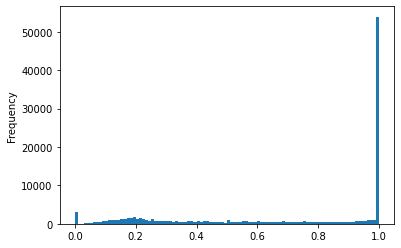

In [13]:
comparison.sort_values("comp_title")["comp_title"].plot.hist(bins=100)

In [14]:
total = len(comparison)
full_match = len(comparison[ comparison["comp_title"] == 1 ][["title_citoid", "title_clean", "comp_title"]])
no_match = len(comparison[ comparison["comp_title"] == 0][["title_citoid", "title_clean", "comp_title"]])

print( f'There is {round(full_match*100/total, 2)}% of full matching titles' )
print( f'There is {round(no_match*100/total, 2)}% of completely different titles (title missing)' )

There is 44.27% of full matching titles
There is 2.62% of completely different titles (title missing)


In first place, we find full matching titles (44% of the cases) and in second place we find missing title from Citoid (3% of the cases). In more than the half of the cases, Citoid's response is different than the manual title.

In [15]:
## best scores (full match excluded)
pd.set_option("colwidth", 200)

comparison[
    (0.7 < comparison["comp_title"]) &
    (comparison["comp_title"] < 0.9)
][["title_citoid", "title_clean", "comp_title"]].sample(6)

,title_citoid,title_clean,comp_title
94610,the hindu world,hindu world,0.733333
11191,ratchet & clank: up your arsenal hd - playstation 3 - gamespy,ratchet & clank: up your arsenal hd - editions,0.704918
7513,uncovered politics - mccotter appoints campaign director in new hampshire,mccotter appoints campaign director in new hampshire,0.712329
7450,"ariana grande ""sweetener"" | ifpi","ariana grande ""sweetener""",0.781250
94194,huan jing sheng _iriomoteyamanekosheng xi zhuang kuang deng zong he diao cha (di 4ci )nojie guo nitsuite(ozhi rase),iriomoteyamanekoSheng Xi Zhuang Kuang Deng Zong He Diao Cha (Di 4Ci )noJie Guo nitsuite(oZhi rase),0.730435
60907,"divisional round - arizona cardinals at minnesota vikings - january 10th, 1999","arizona cardinals at minnesota vikings - january 10th, 1999",0.756410


In [16]:
## middle scores
pd.set_option("colwidth", 200)

comparison[
    (0.4 < comparison["comp_title"]) &
    (comparison["comp_title"] < 0.6)
][["title_citoid", "title_clean", "comp_title"]].sample(6)

,title_citoid,title_clean,comp_title
76406,my abandonment | kirkus reviews,''my abandonment'' by peter rock,0.468750
43143,"the family jewels - marina, marina and the diamonds | songs, reviews, credits | allmusic",''the family jewels''&nbsp;- marina and the diamonds,0.443182
73909,goran fredrik goransson - svenskt biografiskt lexikon,goran fredrik goransson,0.433962
62837,"ordonnances des rois de france de la 3e race, recueillies par ordre chronologique...",ordonnances des rois de france de la troisieme race,0.535714
8310,the formation of the solar system,lecture 13: the nebular theory of the origin of the solar system,0.453125
26700,le puits numero 1,vestige du puits ndeg 1,0.434783


In [17]:
## low scores
pd.set_option("colwidth", 200)

comparison[
    (0.1 < comparison["comp_title"]) &
    (comparison["comp_title"] < 0.4)
][["title_citoid", "title_clean", "comp_title"]].sample(6)

,title_citoid,title_clean,comp_title
64943,l'equipe - l'actualite du sport en continu.,c'est byzance pour les reds,0.232558
75649,the home of cricketarchive,south africa v australia: australia in south africa 1949/50 (1st test),0.157143
109361,gerard genette : narratologie / signo - theories semiotiques appliquees,"la narratologie, dans louis hebert (dir)",0.352113
76577,leon: poblacion por municipios y sexo. (2877),instituto nacional de estadistica,0.200000
16030,explore census data,"geography profile: arlington city, washington",0.200000
31230,"bono, behind the fly: the rolling stone interview",behind the fly,0.285714


### 5.2 Compare source type

Let's see a sample of the source type returned by Citoid and the source type identified by Wikipedia's editors:

In [20]:
comparison[["source_type_citoid", "source_type_map"]].sample(6)

,source_type_citoid,source_type_map
10751,webpage,"[blogPost, email, forumPost, webpage]"
8780,webpage,"[blogPost, email, forumPost, webpage]"
43016,webpage,"[blogPost, email, forumPost, webpage]"
108978,webpage,"[blogPost, email, forumPost, podcast, videoRecording, webpage]"
78907,blogPost,"[blogPost, email, forumPost, webpage]"
113304,webpage,"[magazineArticle, newspaperArticle]"


In [18]:
def compare_source_type(source_type_citoid, source_type_manual):
    '''Compares source_type
    source_type_citoid: string
    source_type_manual: list. Limited set of elements.
    '''
    return int(source_type_citoid in source_type_manual)

In [19]:
comparison["comp_source_type"] = comparison.progress_apply(
    lambda row: compare_source_type(row["source_type_citoid"], row["source_type_map"]),
    axis=1)

100%|██████████| 121478/121478 [00:01<00:00, 64895.20it/s]


In [27]:
comparison[["source_type_citoid", "source_type_map", "comp_source_type"]].sample(6)

,source_type_citoid,source_type_map,comp_source_type
85018,webpage,[],0
120073,blogPost,"[blogPost, email, forumPost, webpage]",1
43142,webpage,"[blogPost, email, forumPost, webpage]",1
69110,book,"[book, manuscript]",1
88478,webpage,"[blogPost, email, forumPost, webpage]",1
8416,webpage,"[blogPost, email, forumPost, podcast, videoRecording, webpage]",1


In [30]:
source_type_match = comparison.comp_source_type.sum()

print(f'There is {round(source_type_match*100/total, 2)}% sucess for source type identification by Citoid')

There is 76.47% sucess for source type identification by Citoid


Let's see the main cases where the source type does not match:

In [31]:
source_no_match = comparison[comparison.comp_source_type == 0][["source_type_citoid", "source_type_map"]] 
source_no_match["source_type_map"] = source_no_match["source_type_map"].map(str)

grouped = source_no_match.groupby(["source_type_citoid", "source_type_map"])
grouped.size().sort_values(ascending=False).head(9)

source_type_citoid  source_type_map                                                           
webpage             ['magazineArticle', 'newspaperArticle']                                       9734
newspaperArticle    ['blogPost', 'email', 'forumPost', 'webpage']                                 3586
webpage             []                                                                            2211
newspaperArticle    ['blogPost', 'email', 'forumPost', 'podcast', 'videoRecording', 'webpage']    1259
blogPost            ['magazineArticle', 'newspaperArticle']                                       1062
webpage             ['book', 'manuscript']                                                         951
videoRecording      ['blogPost', 'email', 'forumPost', 'webpage']                                  944
audioRecording      ['blogPost', 'email', 'forumPost', 'webpage']                                  889
webpage             ['conferencePaper', 'journalArticle', 'presentation', 'report

Webpages and newspaper articles are the sources that present more problems of identification.

### 5.3 Compare publishing source

Let's see a sample of the data to compare:

In [33]:
comparison[["pub_source_citoid", "pub_source_clean"]].sample(6)

,pub_source_citoid,pub_source_clean
26423,cache.boston.com,[boston globe]
62484,guitarworld,[guitar world]
117414,www.oac.cdlib.org,"[online archive of california, california digital library]"
108804,web.archive.org,[the age]
104818,"shambhala publications, incorporated","[boston & london, shambhala]"
56517,www.rsssf.com,[rsssf.com]


Full match comparison as in the previous case would penalize cases as "guitarworld" vs. "guitar world" or "www.rsssf.com" vs. "rsssf.com" as incorrect. This is why we define a new comparing function to consider cases of approximate match:

In [34]:
def compare_pub_source(pub_source_citoid, pub_source_manual):
    '''
    Compares publishing source
    pub_source_citoid: string
    pub_source_manual: list
    '''
    if pub_source_citoid in pub_source_manual:
        return 1
    elif pd.isnull(pub_source_citoid) and not pub_source_manual: ## esto da error para Nan vs. []
        return 1
    else:
        if pub_source_manual: ### NOTA: consideramos que pub_source_manual vacía es lo verdadero
            if pd.isnull(pub_source_citoid):
                return 0
            else:
                score = []
                for element in pub_source_manual:
                    if (pub_source_citoid in element) or (element in pub_source_citoid):
                        score.append(1)
                    else:
                        score.append(compare_strings(pub_source_citoid, element))
                return max(score)

        return 0

In [35]:
comparison["comp_pub_source"] = comparison.progress_apply(
    lambda row: compare_pub_source(row["pub_source_citoid"], row["pub_source_clean"]),
    axis=1)

100%|██████████| 121478/121478 [00:18<00:00, 6528.64it/s]


In [36]:
iguales = len(comparison[ comparison["comp_pub_source"] == 1 ][["pub_source_citoid", "pub_source_clean", "comp_pub_source"]])
distintos = len(comparison[ comparison["comp_pub_source"] == 0][["pub_source_citoid", "pub_source_clean", "comp_pub_source"]])

print( f'There is {round(iguales*100/total, 2)}% of full matching pub_source' )
print( f'There is {round(distintos*100/total, 2)}% of completely different pub source (one missing)')

There is 46.11% of full matching pub_source
There is 24.12% of completely different pub source (one missing)


In [37]:
comparison[
    (0 < comparison["comp_pub_source"])  &
    (comparison["comp_pub_source"] < 1.0)
][["pub_source_citoid","pub_source_clean","comp_pub_source"]].sample(6)

,pub_source_citoid,pub_source_clean,comp_pub_source
17533,www.nhc.noaa.gov,[national hurricane center],0.160000
115785,m.e. sharpe,[m. e. sharpe],0.916667
46000,www.encyclopedie.fr,[l'encyclopedie francaise],0.500000
36648,"nielsen business media, inc.","[billboard, prometheus global media]",0.250000
44928,www.miyamotoshrine.com,[nintendo power],0.136364
54245,"nielsen business media, inc.",[billboard],0.142857


### 5.4 Compare publishing date

In [41]:
comparison[["pub_date_citoid", "pub_date_clean"]].sample(6)

,pub_date_citoid,pub_date_clean
68629,NaN,[]
30889,1998-01-30,[1998-01-29]
5578,2015-06-02,[2015-07-08]
116976,1913-09-03,[1913-09-03]
22953,NaN,[]
8044,NaN,[2016-04-09]


In this case, we first consider if all the elements of the date match, otherwise, we evaluate if the year matches. In this last case, 

In [42]:
def get_year(s):
    return s.split('-')[0]

def compare_dates(pub_date_citoid, pub_date_clean):
    '''Compares date string to array of date strings in YY-MM-DD format. '''
    if pub_date_citoid in pub_date_clean:
        return 1
    else:
        if pub_date_clean and pd.notnull(pub_date_citoid):
            score = []
            year_citoid = get_year(pub_date_citoid)
            for element in pub_date_clean:
                year_manual = get_year(element)
                if year_citoid == year_manual:
                    score.append(0.7) # 0.7 significa coincidencia solo del año
                    break
                else:
                    score.append(0)
            return max(score)
        return 0

In [43]:
comparison["comp_pub_date"] = comparison.progress_apply(
    lambda row: compare_dates(row["pub_date_citoid"], row["pub_date_clean"]),
    axis=1)

100%|██████████| 121478/121478 [00:02<00:00, 59858.70it/s]


In [45]:
comparison[["pub_date_citoid","pub_date_clean","comp_pub_date"]].sample(6)

,pub_date_citoid,pub_date_clean,comp_pub_date
45839,NaN,[],0.0
92824,NaN,[],0.0
69130,2016-03-15,[],0.0
116914,NaN,[],0.0
30987,NaN,[],0.0
106626,NaN,[],0.0


### 5.3 Compare author's first and last names

## Results
    